# EDA
Start with this notebook before moving onto Exploration.ipynb.

This notebook provides a semi-guided exploration of a data set. The purpose is to familiarize yourself with the data, brush up on some common EDA techniques, and prepare for the more open-ended and self-directed task that follows.

In [ ]:
# use the following OneDrive link to download a copy of this file to your device
# either save the downloaded file to the path indicated below or update the path accordingly
# https://perkinelmer-my.sharepoint.com/:x:/p/bryan_romas/EQGG-RAMTVxIhZi4XItMdb4BUyV40MW4JD4RnYF2KyWcaQ?e=FiyVOx

COPPER_FILE = 'data/copper_production_v1.xlsx'

This file contains data from a factory that manufactures copper wire, specifically counts of two types of failures (Cable Failures & Other Failures) and the related amount of downtime captured in minutes (Cable Failure Downtime & Other Failure Downtime).

Overall, the goal is to identify the primary source(s) of failures and downtimes and, if possible, to assess the certainty of those conclusions.  

## Load COPPER_FILE & describe the contents (the number of records, average values, etc.)

In [2]:
# import libraries
import pandas as pd
import numpy as np

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# a simple theme that's better than the default
sns.set_theme(
    context='notebook',
    style='darkgrid', 
    palette='husl',
    rc={"figure.figsize":(24, 8)}
)

In [3]:
# get the path to copper_file
abs_path_copper = os.path.abspath(COPPER_FILE)

# load copper_file
copper_df = pd.read_excel(abs_path_copper, index_col = 0)

In [4]:
# print out the first 5 rows of copper_df
copper_df.head()

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime
0,6,A,12,2020-11-15,0,0,1,60
1,6,B,12,2020-11-10,0,0,0,0
2,2,A,2,2020-11-06,1,10,3,150
3,8,B,13,2020-11-16,3,175,0,0
4,7,B,14,2020-11-21,1,55,0,0


In [5]:
# inspect column datatype and check columns with missing values
copper_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Machine                 154 non-null    int64         
 1   Shift                   154 non-null    object        
 2   Operator                154 non-null    int64         
 3   Date                    154 non-null    datetime64[ns]
 4   Cable Failures          154 non-null    int64         
 5   Cable Failure Downtime  154 non-null    int64         
 6   Other Failures          154 non-null    int64         
 7   Other Failure Downtime  154 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 10.8+ KB


In [6]:
# copper_df initial statistics
copper_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Machine,154.0,5.896104,4.278184,1.0,2.0,5.0,8.00,17.0
Operator,154.0,13.064935,8.608914,1.0,6.0,12.0,18.75,32.0
Cable Failures,154.0,1.383117,1.314564,0.0,0.0,1.0,2.00,6.0
Cable Failure Downtime,154.0,51.461039,56.533654,0.0,0.0,35.0,70.00,295.0
Other Failures,154.0,0.558442,0.996642,0.0,0.0,0.0,1.00,9.0
Other Failure Downtime,154.0,47.402597,105.446794,0.0,0.0,0.0,45.00,690.0


In [7]:
# print out unique shifts
copper_df['Shift'].unique()

array(['A', 'B'], dtype=object)

In [8]:
# print out unique dates
copper_df['Date'].unique()

array(['2020-11-15T00:00:00.000000000', '2020-11-10T00:00:00.000000000',
       '2020-11-06T00:00:00.000000000', '2020-11-16T00:00:00.000000000',
       '2020-11-21T00:00:00.000000000', '2020-11-09T00:00:00.000000000',
       '2020-11-14T00:00:00.000000000', '2020-11-07T00:00:00.000000000',
       '2020-11-18T00:00:00.000000000', '2020-11-19T00:00:00.000000000',
       '2020-11-12T00:00:00.000000000', '2020-11-13T00:00:00.000000000',
       '2020-11-17T00:00:00.000000000', '2020-11-22T00:00:00.000000000',
       '2020-11-08T00:00:00.000000000', '2020-11-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Check for & remove exact duplicates

In [9]:
# a duplicate is defined as two or more records with the same values for all columns in the data
# report the number of duplicates that were removed
print('there are {} exact duplicates in the dataset'.format(len(copper_df) - len(copper_df.drop_duplicates())))

there are 5 exact duplicates in the dataset


In [10]:
# remove the duplicates
copper_df = copper_df.drop_duplicates()

# print the number of rows after removing duplicates
print('there are {} rows of data after exact duplicate removal'.format(copper_df.shape[0]))

there are 149 rows of data after exact duplicate removal


## Combine multiple records

In [11]:
# there shouldn't be more than one record per Machine-Shift-Operator-Date combination
# combine any such records so the resulting record contains the sums of the remaining columns
dup_rows = copper_df.copy()

combination = ['Machine', 'Shift', 'Operator', 'Date']

dup_rows = dup_rows[copper_df.duplicated(subset=combination, keep=False)]
dup_rows = pd.DataFrame(dup_rows.groupby(combination)[['Cable Failures', 'Cable Failure Downtime', 'Other Failures', 'Other Failure Downtime']].sum())
dup_rows.reset_index(inplace = True)
dup_rows

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime
0,5,A,9,2020-11-17,3,160,0,0
1,7,A,9,2020-11-21,2,65,0,0
2,7,B,14,2020-11-21,4,120,1,30
3,8,B,13,2020-11-21,2,65,2,210


In [12]:
# drop duplicated rows from copper_df and add dup_rows combinatio

copper_df = copper_df.drop_duplicates(subset = combination, keep = False)
print('copper_df shape before adding dup_rows: {}'.format(copper_df.shape))

# add dup_rows to copper_df
dfs = [copper_df, dup_rows]

copper_df = pd.concat(dfs).reset_index(drop=True)
print('copper_df shape after adding dup_rows: {}'.format(copper_df.shape))

copper_df shape before adding dup_rows: (141, 8)
copper_df shape after adding dup_rows: (145, 8)


## Load & process OPERATOR_FILE

In [13]:
# similar process to COPPER_FILE
# https://perkinelmer-my.sharepoint.com/:t:/p/bryan_romas/EQLgOytFSANKtmt1zKFF7tMBaiLXru6Blscn8kqlyr7t2w?e=M5E5cb

OPERATOR_FILE = 'data/operator_names.txt'

This file contains a mapping between operator numbers and names. In general, the contents are formatted in the following manner: {operator number}{first name}{last name}.

Overall, the goal is to load the file; extract the operator number, first name, and last initial; and merge or map those names into copper_df so you can reference the operators' first names and last initials instead of their numbers in the subsequent analysis.

Ideally, you'll load the file and extract the necessary content by completing the function definition below (get_operator_names). However, if this proves too challenging then you may take any other programmatic approach to accomplish the goal. However, don't manually copy the file contents into the notebook or manipulate the contents of the file so the task is easier.

In [14]:
# load & process OPERATOR_FILE
# HINT: you may want to use regex here
import re

def get_operator_names(operator_file: str)->pd.DataFrame:
    """
    Load & process the contents of a file containing operator details.
    
    Params:
    operator_file - str; the path to the operator file.
    
    Returns:
    operator_df - pd.DataFrame; the extracted content of the operator file. The
        columns should include Operator Number, First Name, & Last Initial.
    """
    assert isinstance(operator_file, str), 'operator_file is not of type str.'
    
    # create column reference
    columns=['Operator Number','First Name','Last Initial']
    
    # load operator file
    operator = pd.read_csv(operator_file,
                           sep=r',', 
                           header = None,
                           names = columns,
                           delim_whitespace=True)
    
    # extract initial for last name
    operator['Last Initial'] = operator['Last Initial'].astype(str).str[0]
    
    # create an empty df to fill with contents of operator_file
    operator_df = pd.DataFrame(operator)
    
    return operator_df

In [15]:
# get the absolute path to the operator file
abs_path_operator = os.path.abspath(OPERATOR_FILE)

# process and print out the first 5 rows of operator_df
operator_df = get_operator_names(abs_path_operator)

operator_df.head()

,Operator Number,First Name,Last Initial
0,11,Nichole,H
1,19,David,S
2,3,Hess,H
3,4,Lilly,Z
4,5,Archy,B


In [16]:
# get column datatype info
operator_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Operator Number  41 non-null     int64 
 1   First Name       41 non-null     object
 2   Last Initial     41 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.1+ KB


In [17]:
# merge copper_df with operator_df using on 'Operator' = 'Operator Number'
combined_df = copper_df.merge(operator_df, 
                              how='left', 
                              left_on='Operator', 
                              right_on='Operator Number')

# drop duplicated column & inspect the new combined table
combined_df.drop('Operator', axis=1, inplace=True)

combined_df.head()

,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,First Name,Last Initial
0,6,A,2020-11-15,0,0,1,60,12,Tad,S
1,6,B,2020-11-10,0,0,0,0,12,Tad,S
2,2,A,2020-11-06,1,10,3,150,2,Hugh,R
3,8,B,2020-11-16,3,175,0,0,13,Marcel,C
4,2,B,2020-11-09,0,0,1,20,1,Courtney,H


In [18]:
# print out the shape of the new combined_df
combined_df.shape

(145, 10)

## How many unique Machines, Shifts, & Operator Names are included in the data? Plot the proportion of the total for each.

Below is an example of the first plot you'll create.

![image](img/machine_proportions.PNG)

### Machines

In [39]:
# get the total number of unique Machines in the data as well as the proportion of the total (i.e. normalized count)
# get the total number of unique machines
print('There are {} unique machines within the dataset'.format(combined_df['Machine'].nunique()))

# get the proportion of machines (% per total)
machine_proportion= combined_df['Machine'].value_counts(normalize = True, ascending = False)

machine_proportion

There are 17 unique machines within the dataset


2     0.186207
3     0.131034
7     0.110345
1     0.103448
8     0.075862
5     0.062069
6     0.055172
4     0.055172
10    0.041379
15    0.034483
16    0.034483
9     0.027586
11    0.020690
13    0.020690
14    0.020690
12    0.013793
17    0.006897
Name: Machine, dtype: float64

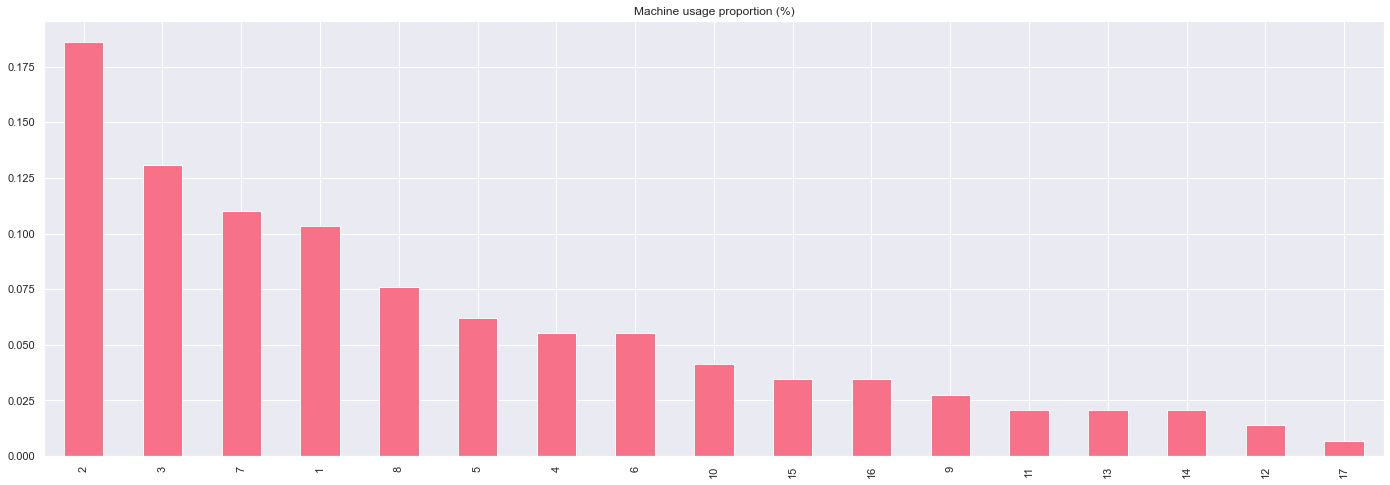

In [40]:
# plot each Machines's proportion of the total
# HINT: for a simple bar chart you can call .plot() on a pd.Series or pd.DataFrame
machine_proportion.sort_values(ascending=False).plot(kind='bar',
                                                     title = 'Machine usage proportion (%)')

It looks like machine 2, 3, 7, and 1 are the most heavily ultilized machines for copper production in this specific dataset

### Shifts

In [41]:
# get the total number of unique Shifts in the data as well as the proportion of the total (i.e. normalized count)
shift_proportion= combined_df['Shift'].value_counts(normalize = True, ascending = False)

shift_proportion

A    0.510345
B    0.489655
Name: Shift, dtype: float64

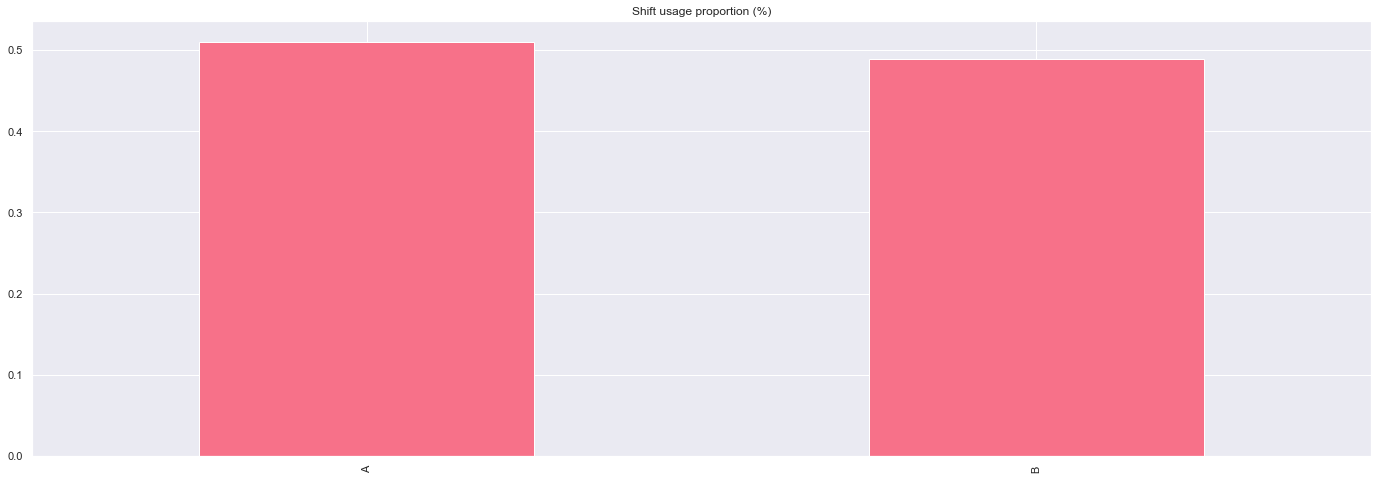

In [42]:
# plot each Shift's proportion of the total, same idea as above
shift_proportion.sort_values(ascending=False).plot(kind='bar',
                                                   title = 'Shift usage proportion (%)')

The number of shifts are equally proportioned between shift A and shift B

### Operator Names

In [43]:
# get the total number of unique Operator Names in the data as well as the proportion of the total (i.e. normalized count)
combined_df['Operator Name'] = pd.DataFrame(combined_df['First Name'] + '_' + combined_df['Last Initial'])

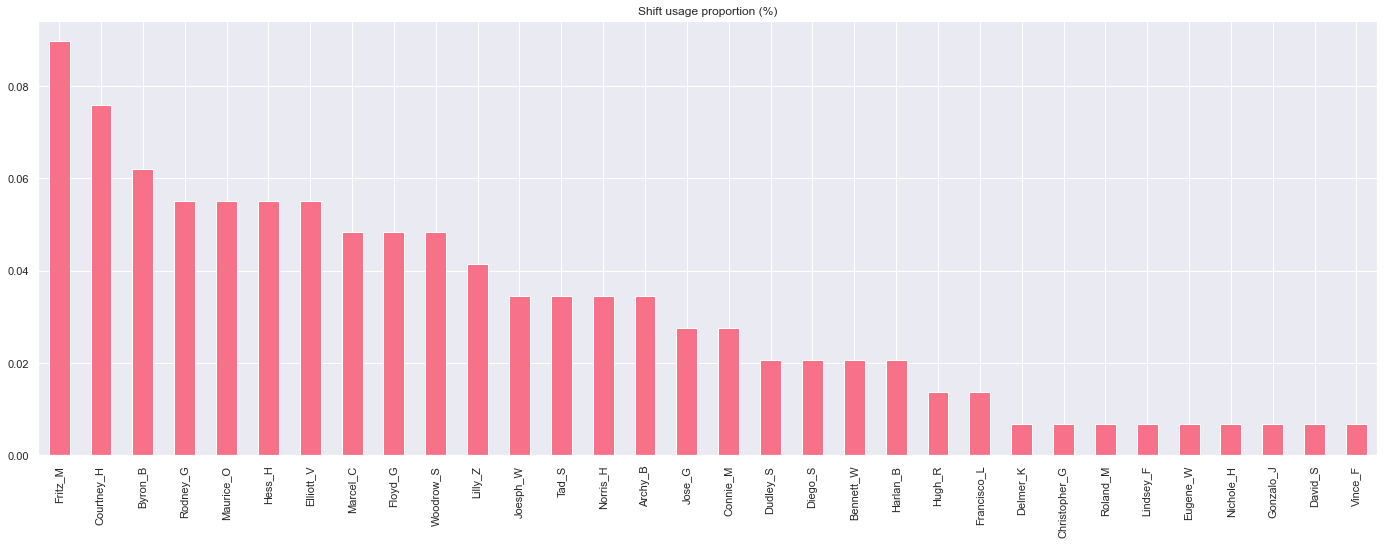

In [44]:
# plot each Operators's proportion of the total, again the same as above
operator_proportion= combined_df['Operator Name'].value_counts(normalize = True, ascending = False)

operator_proportion.sort_values(ascending=False).plot(kind='bar',
                                            title = 'Shift usage proportion (%)')

According to the above chart, Fritz_M and Courtney_H operates the highest number of shifts

## How many dates are included in the data?

In [45]:
# get the total number of Dates in the data as well as how many records exist for each
print('There are {} unique dates in the dataset'.format(combined_df['Date'].nunique()))

combined_df.groupby('Date')['Date'].count()

There are 16 unique dates in the dataset


Date
2020-11-06     3
2020-11-07     2
2020-11-08     4
2020-11-09     6
2020-11-10    14
2020-11-12     9
2020-11-13    12
2020-11-14    13
2020-11-15    12
2020-11-16     7
2020-11-17    12
2020-11-18    10
2020-11-19     8
2020-11-20     7
2020-11-21    13
2020-11-22    13
Name: Date, dtype: int64

### Are any dates that should be covered by the range of the data missing? If so, which and how could this be addressed?

In [46]:
# identify if any dates are missing in the data
# if so, simply explain how the missing data could be addressed no need to solve it in code here

date_max = combined_df['Date'].max()
date_min = combined_df['Date'].min()

pd.date_range(start = date_min, end = date_max).difference(combined_df['Date'])

DatetimeIndex(['2020-11-11'], dtype='datetime64[ns]', freq=None)

There are a few ways that we can impute the data for the missing date.

- 2020-11-11 was a Wednesday. We could use the data for the next Wednesday (2020-11-18) to impute the missing data. If we use this techique, we assume that the there is a relationship between the day of the week and the number of failure/downtime. For example, there tends to be more failures/downtimes that happen on Wednesday because the factory don't have a full staff on Wednesday?

- Another way to impute data for 2020-11-11 entry is to use the mean/median of a certain time period. For example, we can assume that the number of failures/downtimes for Wednesday could equal to the mean/median number of failures/downtimes for the previous week, or the previous trailing 7 days, etc.

- Another method we can use is Last observation carried forward (LOCF) or using Next observation carried forward (NOCF)

## Create 'Day of Week' column

In [28]:
# insert a new column indicating the day of the week e.g., Monday
combined_df['Day of Week'] = combined_df['Date'].dt.day_name()

# map date range and day of week
combined_df.groupby('Date')['Day of Week'].unique()

Date
2020-11-06       [Friday]
2020-11-07     [Saturday]
2020-11-08       [Sunday]
2020-11-09       [Monday]
2020-11-10      [Tuesday]
2020-11-12     [Thursday]
2020-11-13       [Friday]
2020-11-14     [Saturday]
2020-11-15       [Sunday]
2020-11-16       [Monday]
2020-11-17      [Tuesday]
2020-11-18    [Wednesday]
2020-11-19     [Thursday]
2020-11-20       [Friday]
2020-11-21     [Saturday]
2020-11-22       [Sunday]
Name: Day of Week, dtype: object

## Create 'Total Failures' & 'Total Downtime' columns

In [29]:
# insert two new columns to calculate the simple sum of failures & downtime for a given record
combined_df['Total Failures'] = combined_df['Cable Failures'] + combined_df['Other Failures']
combined_df['Total Failure Downtime'] = combined_df['Cable Failure Downtime'] + combined_df['Other Failure Downtime']

combined_df.head()

,Machine,Shift,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Number,First Name,Last Initial,Operator Name,Day of Week,Total Failures,Total Failure Downtime
0,6,A,2020-11-15,0,0,1,60,12,Tad,S,Tad_S,Sunday,1,60
1,6,B,2020-11-10,0,0,0,0,12,Tad,S,Tad_S,Tuesday,0,0
2,2,A,2020-11-06,1,10,3,150,2,Hugh,R,Hugh_R,Friday,4,160
3,8,B,2020-11-16,3,175,0,0,13,Marcel,C,Marcel_C,Monday,3,175
4,2,B,2020-11-09,0,0,1,20,1,Courtney,H,Courtney_H,Monday,1,20


## Plot the sum of downtimes by 'Date'

Below is an example of this plot.

![image](img/downtimes_by_date.PNG)

In [30]:
# prep the data, calculate sums
# HINT: you may want to group the data by Date & use an aggregation function like .sum()
downtime = combined_df.groupby('Date')[['Cable Failure Downtime', 'Other Failure Downtime', 'Total Failure Downtime']].sum()

downtime.head()

,Cable Failure Downtime,Other Failure Downtime,Total Failure Downtime
Date,,,
2020-11-06,85,290,375
2020-11-07,160,115,275
2020-11-08,220,40,260
2020-11-09,380,115,495
2020-11-10,915,55,970


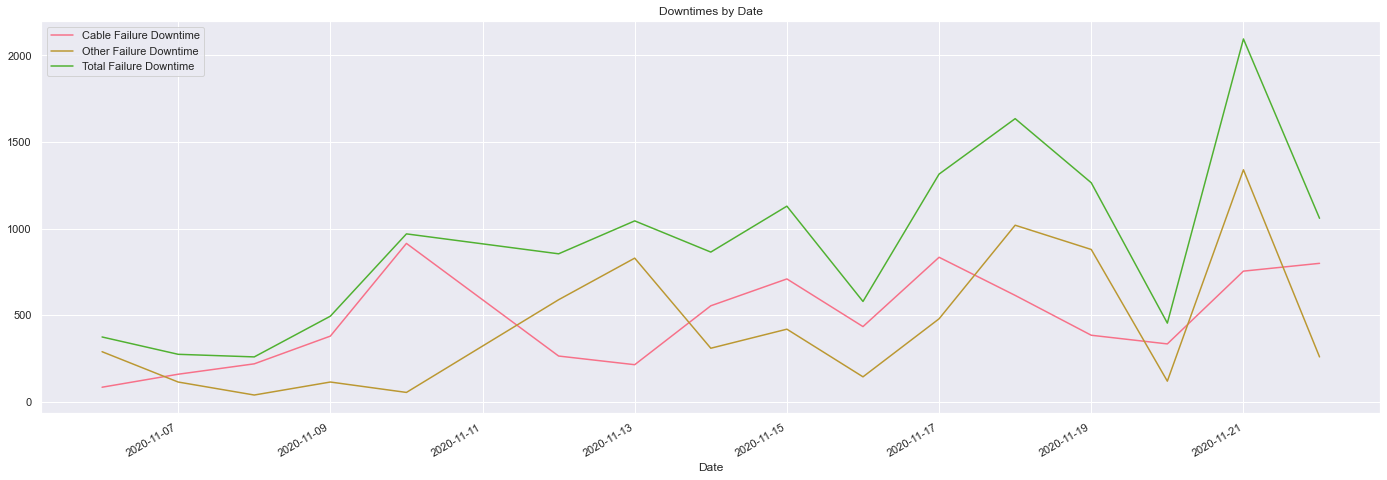

In [31]:
# line chart with 'Date' along the x-axis (in ascending chronological order), minutes along the y-axis, & three lines: Cable Failure Downtime, Other Failure Downtime, & Total Failure Downtime
# HINT: you'll likely want to call plt.plot() once for each line you're plotting 

downtime.plot(kind='line',
              title = 'Downtimes by Date')

## Plot the mean downtime by 'Day of Week'

In [32]:
# prep the data, calculate means
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

mean_downtime = combined_df.groupby('Day of Week')['Total Failure Downtime'].mean()

mean_downtime

Day of Week
Friday        85.227273
Monday        82.692308
Saturday     115.535714
Sunday        84.482759
Thursday     124.705882
Tuesday       87.884615
Wednesday    163.500000
Name: Total Failure Downtime, dtype: float64

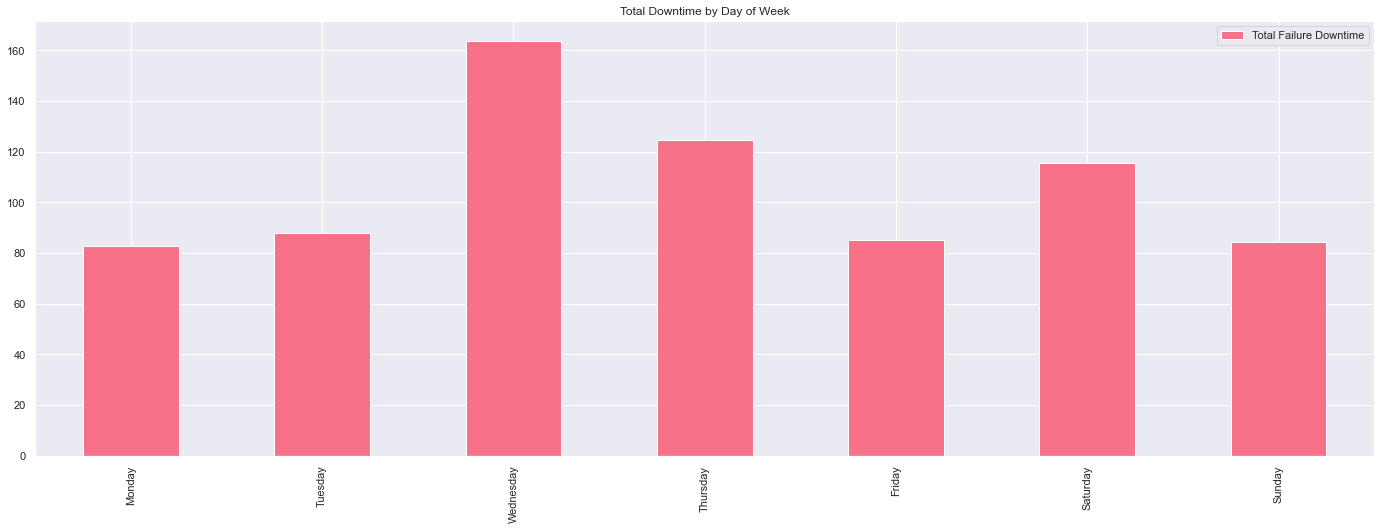

In [33]:
# plot mean downtime by day of the week
mean_downtime = pd.DataFrame(mean_downtime, index = order)

mean_downtime.plot(kind='bar',
                   title = 'Total Downtime by Day of Week')

According to the bar chart above, Wednesday tends to have the highest average number of downtime. It is significantly higher than other days of the week.

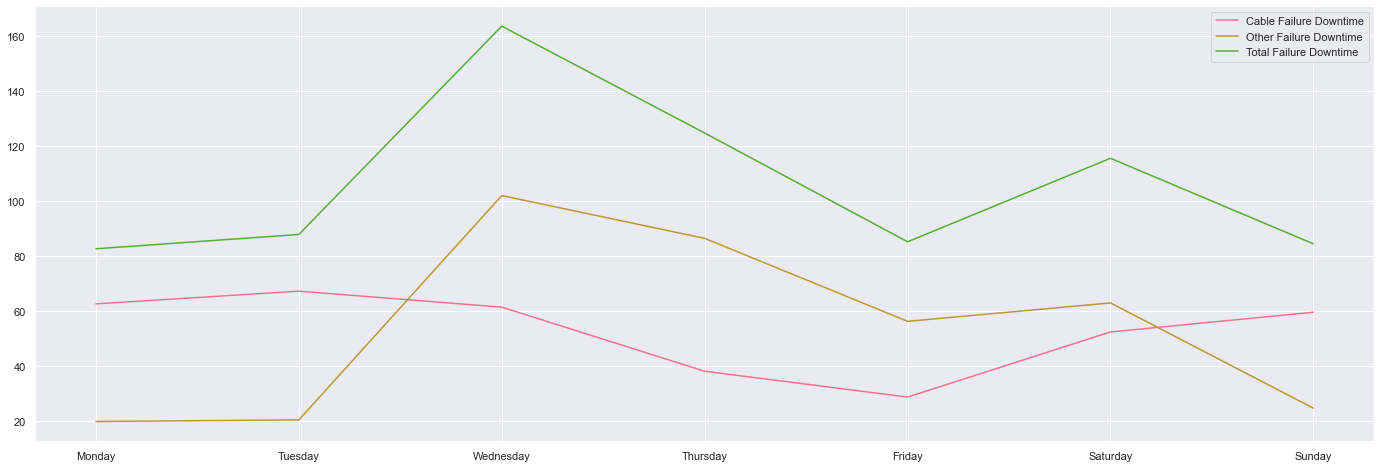

In [34]:
# line chart with 'Day of Week' along the x-axis, minutes along the y-axis, & three lines: Cable Failure Downtime, Other Failure Downtime, & Total Failure Downtime
total_by_dow = combined_df.groupby('Day of Week')['Cable Failure Downtime', 'Other Failure Downtime', 'Total Failure Downtime'].mean()
total_by_dow = pd.DataFrame(total_by_dow, index = order)

total_by_dow.plot(kind='line')

The bar plot above shows Wednesday as the day that tends to have the higest average downtime within our time series. However, the line plot showing Saturday and Sunday are the days with the most number of total failure downtime. Why is that so? 

It's because the time series that we have are skewed:

- The series captured a 2-and-a-half week period starting from Friday of the first week and ending on the Sunday of the third week. This means the number of failures and downtimes on Friday, Saturday, and Sunday were repeated more times than any other days of the week. That's why when we performed a aggregation based on sum of failures/downtimes, we saw a spike during the weekend.

- In addition to that, the statistics for Wednesday 2020-11-11 were missing.This would potentially positively skewed both the sum and average aggregation, unless we assume that there was no failure/downtime on 2020-11-11.

# End